In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Analysis of the Dynamic Solow Model

### Imports 

In [2]:
import pickle
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go

In [4]:
from solowModel import SolowModel
from phase_diagram import PhaseDiagram

ModuleNotFoundError: No module named 'numdifftools'

## Approximation of the Asymptotic Constants

#### Solver Functions

In [116]:
def numerical_psi(sm):
    psi_ks_bar = (sm.path.ks.iloc[-1] - sm.path.ks.iloc[0]) / sm.path.shape[0]
    psi_y_bar = (sm.path.y.iloc[-1] - sm.path.y.iloc[0]) / sm.path.shape[0]
    psi_kd_bar = (sm.path.kd.iloc[-1] - sm.path.kd.iloc[0]) / sm.path.shape[0]   
    return [psi_y_bar, psi_ks_bar, psi_kd_bar]

In [132]:
def approximate_g(sm):
    p = sm.params
    psi = numerical_psi(sm)
    return psi[2] / (p['c2']*p['beta2']*p['gamma']*psi[0])

In [206]:
def lr_s(sm):
    psi = numerical_psi(sm)
    return psi[2]/sm.params['c2']

In [118]:
def approximate_qg(sm):
    sbar = sm.sbars
    p = sm.params
    psi = numerical_psi(sm)
    
    q = (psi[2] - p['c2']*p['beta2']*p['gamma']*psi[0]) / p['c2']
    
    g = (psi[0] - p['rho']*p['c2']*q + p['epsilon']) / (p['rho']*p['c2']*p['beta2']*p['gamma'])
    
    return [q, g]

In [158]:
def name_extractor(filename):
    temp = filename.split('_')
    g = 'g_'+str(int(temp[2][1:]))
    c2 = 'c2_'+str(float(temp[7]))
    e = 'e_'+str(float(temp[3][1:]))
    return '_'.join([g,c2,e])
    

### Simulation Analysis

#### Computation

In [196]:
models = {}
for filename in os.listdir('long_run_approx'):
    name = name_extractor(filename)
    if not name in models.keys():
        models[name] = {}
    file = open('long_run_approx/'+filename, 'rb')
    models[name][filename[-6:-4]] = pickle.load(file)

In [197]:
print(models.keys())
print([len(x.keys()) for i,x in models.items()])

dict_keys(['g_2000_c2_0.0003_e_1e-05', 'g_2000_c2_0.0004_e_1e-05', 'g_2000_c2_0.0002_e_1e-05', 'g_1000_c2_0.0003_e_1e-05'])
[73, 29, 29, 1]


#### Visuals

Histogram of the distributions of g and gq

In [198]:
g = {}
for model_class in models.keys():
    g[model_class] = []
    for seed, model in models[model_class].items():
        g[model_class].append(approximate_g(model))
        #print("Seed: {}\ng = {}".format(seed, g[seed]))

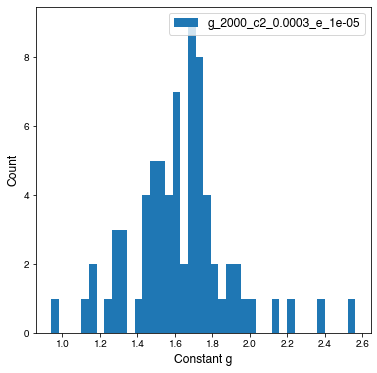

In [199]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
for model_class in list(models.keys())[:1]:
    ax.hist(g[model_class], bins=40, label=model_class)
ax.set_xlabel('Constant g')
ax.set_ylabel('Count')
ax.legend()
plt.show()


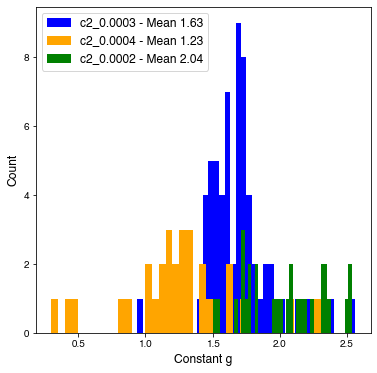

In [234]:
temp = []
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
colors=['Blue', 'Orange','Green']
for i, model_class in enumerate(list(models.keys())[:3]):
    t = ax.hist(g[model_class], bins=40, label=model_class[7:16]+' - Mean {:.2f}'.format(np.mean(g[model_class])), color=colors[i])
    #mode = t[1][np.argmax(t[0])]
    #ax.axvline(mode, color=colors[i])
    
ax.set_xlabel('Constant g')
ax.set_ylabel('Count')
ax.legend()
plt.show()


Histogram of the difference in psi_y and psi_ks

In [201]:
diff_psi_yks = {}
diff_psi_kskd = {}

for model_class in models.keys():
    diff_psi_yks[model_class] = []
    diff_psi_kskd[model_class] = []
    for seed, model in models[model_class].items():
        temp = numerical_psi(model)
        diff_psi_yks[model_class].append(temp[0]-temp[1])
        diff_psi_kskd[model_class].append(temp[1]-temp[2])

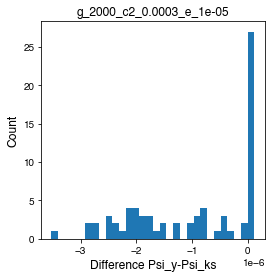

In [202]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)
for i,model_class in enumerate(list(models.keys())[:1]):
    ax.hist(diff_psi_yks[model_class], bins=30, label=model_class)
    ax.set_xlabel('Difference Psi_y-Psi_ks')
    ax.set_ylabel('Count')
    ax.set_title(model_class)
plt.show()

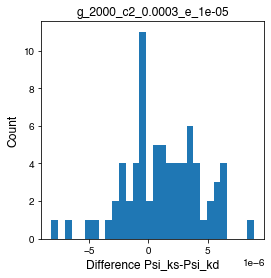

In [203]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)
for i,model_class in enumerate(list(models.keys())[:1]):
    ax.hist(diff_psi_kskd[model_class], bins=30, label=model_class)
    ax.set_xlabel('Difference Psi_ks-Psi_kd')
    ax.set_ylabel('Count')
    ax.set_title(model_class)
plt.show()

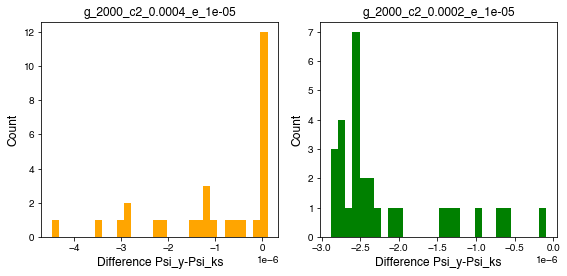

In [204]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
colors = ['orange', 'green']
for i,model_class in enumerate(list(models.keys())[1:3]):
    ax[i].hist(diff_psi_yks[model_class], bins=30, label=model_class, color=colors[i])
    ax[i].set_xlabel('Difference Psi_y-Psi_ks')
    ax[i].set_ylabel('Count')
    ax[i].set_title(model_class)
plt.tight_layout()
plt.show()


Histogram of the difference in psi_ks and psi_kd

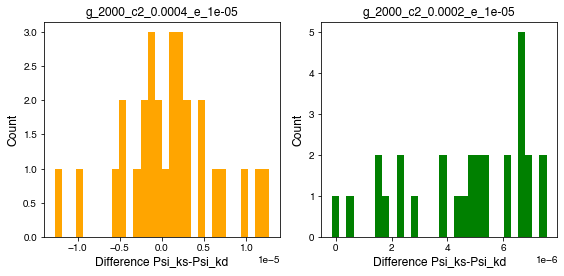

In [205]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
colors = ['orange', 'green']
for i,model_class in enumerate(list(models.keys())[1:3]):
    ax[i].hist(diff_psi_kskd[model_class], bins=30, label=model_class, color=colors[i])
    ax[i].set_xlabel('Difference Psi_ks-Psi_kd')
    ax[i].set_ylabel('Count')
    ax[i].set_title(model_class)
plt.tight_layout()
plt.show()


In [215]:
sbars = {}

for model_class in models.keys():
    sbars[model_class] = []
    for seed, model in models[model_class].items():
        temp = numerical_psi(model)
        sbars[model_class].extend([temp[2] / model.params['c2']])

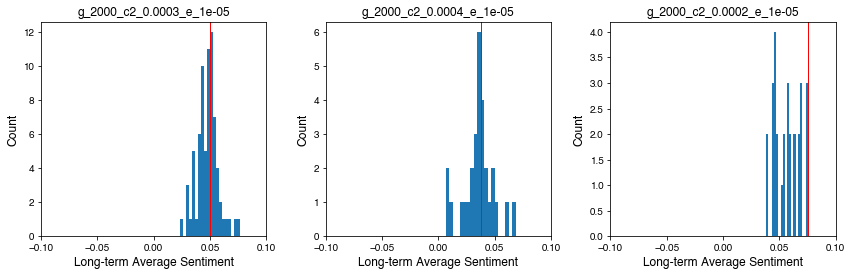

In [224]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,4)
for i, model_class in enumerate(list(models.keys())[:3]):
    ax[i].hist(sbars[model_class], bins=20, label=model_class)
    ax[i].set_xlabel('Long-term Average Sentiment')
    ax[i].set_ylabel('Count')
    ax[i].set_title(model_class)
    ax[i].set_xlim(-0.1,0.1)
    keys = list(models[model_class].keys())
    p = models[model_class][keys[0]].params
    ax[i].axvline(p['epsilon']/(p['c2']*(1-p['rho'])), color='Red')
plt.tight_layout()
plt.show()

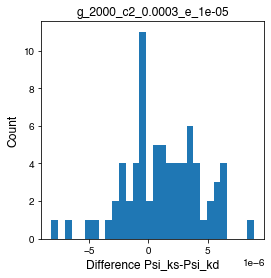

In [203]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)
for i,model_class in enumerate(list(models.keys())[:1]):
    ax.hist(diff_psi_kskd[model_class], bins=30, label=model_class)
    ax.set_xlabel('Difference Psi_ks-Psi_kd')
    ax.set_ylabel('Count')
    ax.set_title(model_class)
plt.show()

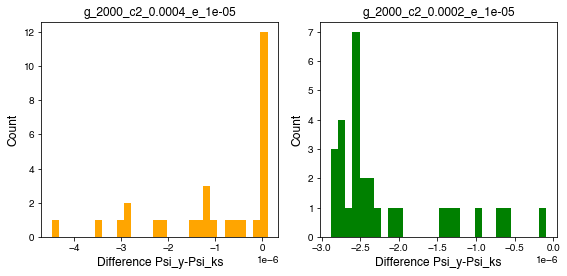

In [204]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
colors = ['orange', 'green']
for i,model_class in enumerate(list(models.keys())[1:3]):
    ax[i].hist(diff_psi_yks[model_class], bins=30, label=model_class, color=colors[i])
    ax[i].set_xlabel('Difference Psi_y-Psi_ks')
    ax[i].set_ylabel('Count')
    ax[i].set_title(model_class)
plt.tight_layout()
plt.show()


Histogram of the difference in psi_ks and psi_kd

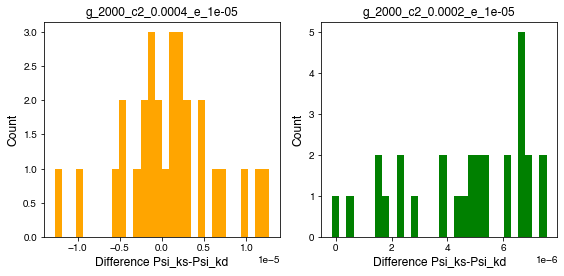

In [205]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
colors = ['orange', 'green']
for i,model_class in enumerate(list(models.keys())[1:3]):
    ax[i].hist(diff_psi_kskd[model_class], bins=30, label=model_class, color=colors[i])
    ax[i].set_xlabel('Difference Psi_ks-Psi_kd')
    ax[i].set_ylabel('Count')
    ax[i].set_title(model_class)
plt.tight_layout()
plt.show()


## Optimisation of the Code

In [11]:
import time

The solver successfully reached the end of the integration interval.
Time: 00:00:48


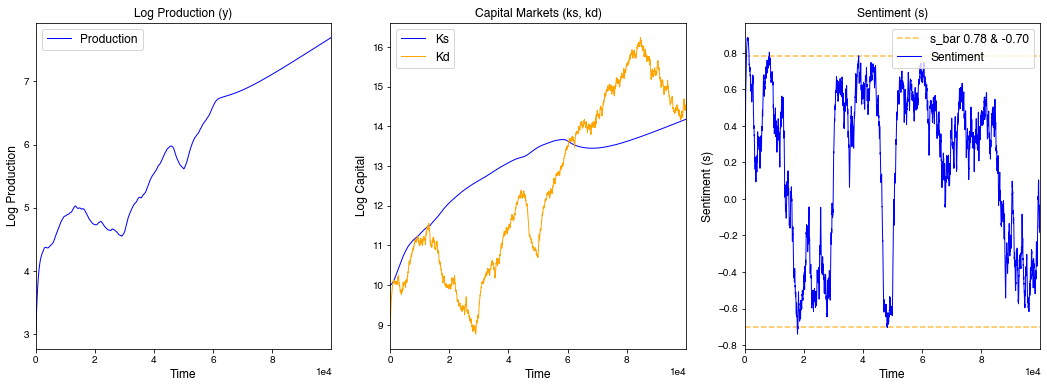

In [74]:
t = time.time()
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 3e-4, "gamma":2000,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params)
path, steps = sm.solve(start, t_end=1e5, seed=42, case='general')
sm.save_path(folder='test/', case='general')
_ = sm.overview(asymptotics=False)
print("Time: {}".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - t))))

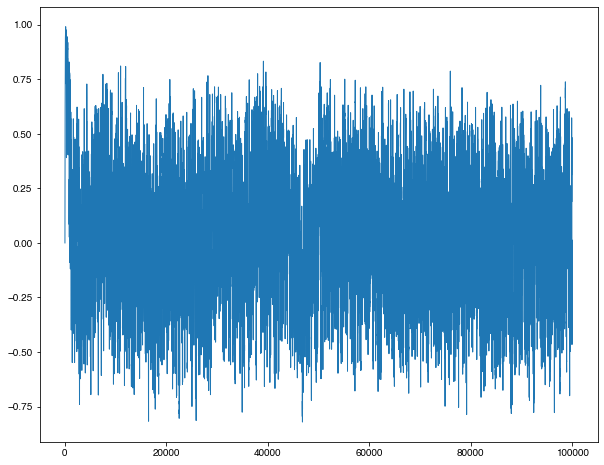

In [75]:
plt.plot(path.h)
plt.show()

The solver successfully reached the end of the integration interval.
Time: 00:00:01


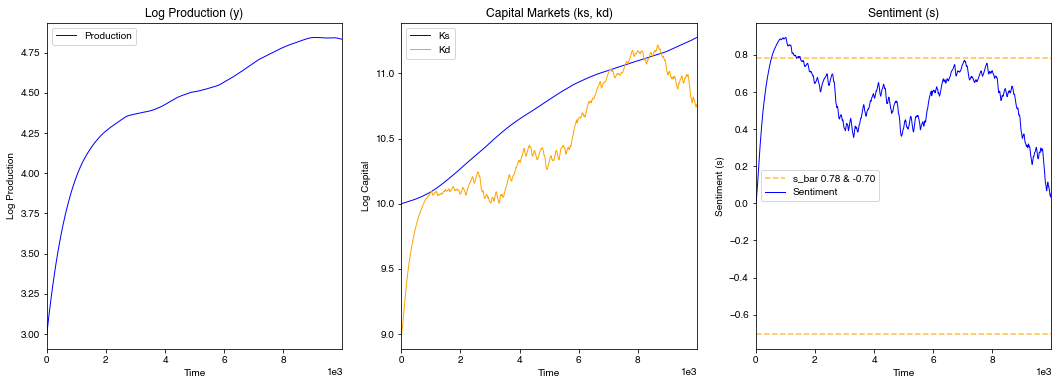

In [21]:
t = time.time()
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 3e-4, "gamma":2000,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params)
path = sm.solve(start, t_end=1e4, seed=42, case='general')
sm.save_path(folder='test/', case='general')
_ = sm.overview(asymptotics=False)
print("Time: {}".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - t))))

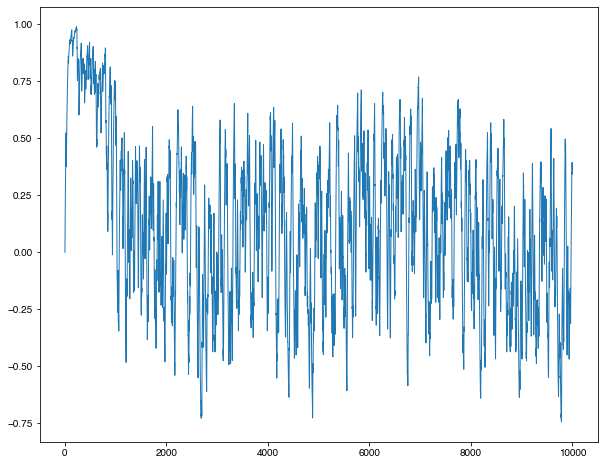

In [22]:
plt.plot(path.h)
plt.show()

## Alternative Version

In [84]:
from solow_cases import alternate_general

def simulate(t_end, interval, start, params, decay, diffusion, seed):
    # News process
    np.random.seed(seed)
    stoch = np.random.normal(0, np.sqrt(interval), int(t_end / interval))
    xi = np.zeros((int(t_end / interval), 1))
    for i in range(1, int(t_end / interval)):
        xi[i] = (1 - interval * decay) * xi[i-1] + diffusion * stoch[i]

    values = np.empty((int(t_end / interval), len(start)))
    values[0, :] = start

    for t in range(1, xi.shape[0]):
        velocity = alternate_general(t, values[t - 1, :], **params, news=xi[t])
        values[t, :] = values[t-1, :] + interval*velocity

    return pd.DataFrame(values[::int(1 / interval), :],
                        columns=['y', 'ks', 'kd', 's', 'h', 'g', 'lam'])


Time: 00:00:28


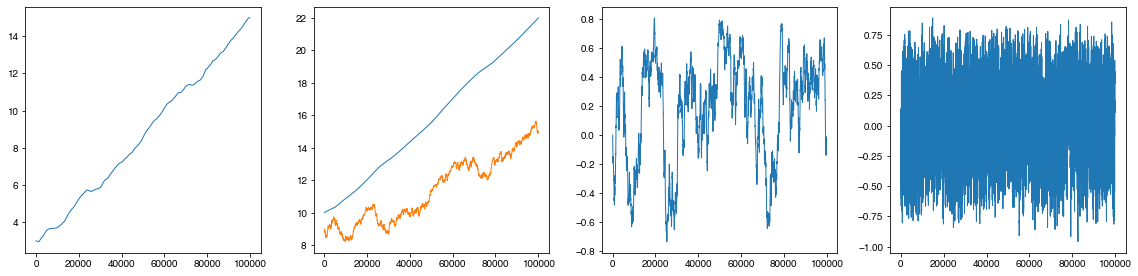

In [99]:
params = {
        'tech0': 1, 'rho': 1 / 3, 'epsilon': 1e-5, 'tau_y': 1000,
        'dep': 0.0002,
        "tau_h": 25, "tau_s": 250, "c1": 1, "c2": 3.2e-4, "gamma": 1000,
        "beta1": 1.1, "beta2": 1.0, 'saving0': 0.15, "h_h": 10
}

start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
# Accurate production adjustment
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

t = time.time()
path = simulate(t_end=1e5, interval=0.1, start=start, params=params, seed=2,
                decay=0.2, diffusion=2.0)
print("Time: {}".format(
        time.strftime("%H:%M:%S", time.gmtime(time.time() - t))))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(16, 4)
ax[0].plot(path.y)
ax[1].plot(path.ks, label='ks')
ax[1].plot(path.kd, label='kd')
ax[2].plot(path.s)
ax[3].plot(path.h)
plt.tight_layout()
plt.show()

In [65]:
temp = [1.0,1.02,1.03,1.08,1.088888888888889,1.1,1.1,1.2335733079820899,1.3003599619731345,1.6342932319283587,1.6936591465870654,1.7678665399104485,1.7678665399104485,2.742447267447147,3.229737631215496,5.666189450057242,6.099336440073552,6.64077017759394,6.64077017759394,7.717796317912249,8.256309388071404,10.948874738867175,11.427553023453092,12.025900879185485,12.025900879185485,13.104055300588964,13.643132511290702,16.338518564799397,16.817698307645387,17.416672986202876,17.416672986202876,19.58318759281382,20.66644489611929,26.082731412646652,27.04562679336263,28.249246019257598,28.249246019257598,30.41788489389993,31.502204331221098,36.92380151782693,37.88764101766797,39.092440392469264,39.092440392469264]

t = 29.262347957960817
x = np.array(temp)
#np.max(x[x<t])
loc = x.searchsorted(t, side='right') - 1
print(x[loc-1:loc+2])
print(x[:loc+1])

[28.24924602 28.24924602 30.41788489]
[ 1.          1.02        1.03        1.08        1.08888889  1.1
  1.1         1.23357331  1.30035996  1.63429323  1.69365915  1.76786654
  1.76786654  2.74244727  3.22973763  5.66618945  6.09933644  6.64077018
  6.64077018  7.71779632  8.25630939 10.94887474 11.42755302 12.02590088
 12.02590088 13.1040553  13.64313251 16.33851856 16.81769831 17.41667299
 17.41667299 19.58318759 20.6664449  26.08273141 27.04562679 28.24924602
 28.24924602]


In [70]:
loc, prior = next((len(temp)-i-1,t_p) for i,t_p in enumerate(temp[::-1]) if t_p<t)
print(loc, prior)

36 28.249246019257598


In [73]:
x[:38]
x[36]

28.249246019257598

In [40]:
np.append(np.zeros((4,1)),5)

array([0., 0., 0., 0., 5.])

In [16]:
def name_extractor(filename):
    temp = filename.split('_')
    g = 'g_'+str(int(temp[2][1:]))
    c2 = 'c2_'+str(float(temp[7]))
    e = 'e_'+str(float(temp[3][1:]))
    return '_'.join([g,c2,e])

In [23]:
import pickle
import os

files = os.listdir('new/asymptotic_simulations')
sims = {}

for path in files:
    file = open('new/asymptotic_simulations/'+path, 'rb')
    sims[name_extractor(path)] = pickle.load(file)
    file.close()

In [34]:
sims[list(sims.keys())[0]]

,psi_y,psi_ks,psi_kd,g,sbar_hat,sbar_theory,sbar_crit
0,0.000114862,0.00011512,4.50536e-05,2.0115,0.343954,0.346566,0.115385
1,0.000113904,0.000114065,4.19491e-05,1.88864,0.320407,0.322685,0.115385
2,0.000114804,0.000115047,4.47349e-05,1.99828,0.342872,0.344115,0.115385
3,0.000115525,0.000115839,4.69694e-05,2.085,0.360802,0.361303,0.115385
4,0.000112744,0.000112943,3.85239e-05,1.75228,0.294203,0.296338,0.115385
...,...,...,...,...,...,...,...
95,0.000115058,0.000115166,4.56446e-05,2.03441,0.345871,0.351112,0.115385
96,0.00011397,0.000114076,4.21709e-05,1.89752,0.320837,0.324391,0.115385
97,0.000113018,0.00011312,3.93507e-05,1.78554,0.298736,0.302698,0.115385
98,0.000113904,0.000114331,4.21791e-05,1.89899,0.324777,0.324455,0.115385


In [25]:
sims.keys()

dict_keys(['g_1500_c2_0.00013_e_1e-05', 'g_2000_c2_0.00037_e_1e-05', 'g_1500_c2_0.0004_e_1e-05', 'g_3000_c2_0.0001_e_1e-05', 'g_2500_c2_0.0004_e_1e-05', 'g_1000_c2_0.00037_e_1e-05', 'g_2500_c2_0.00013_e_1e-05', 'g_1500_c2_0.00031_e_1e-05', 'g_1000_c2_0.00019_e_1e-05', 'g_1500_c2_0.00025_e_1e-05', 'g_2500_c2_0.00025_e_1e-05', 'g_3000_c2_0.00022_e_1e-05', 'g_2000_c2_0.00019_e_1e-05', 'g_2500_c2_0.00031_e_1e-05', 'g_1000_c2_0.00028_e_1e-05', 'g_1500_c2_0.0001_e_1e-05', 'g_2000_c2_0.00034_e_1e-05', 'g_3000_c2_0.0004_e_1e-05', 'g_2000_c2_0.00028_e_1e-05', 'g_3000_c2_0.00013_e_1e-05', 'g_1000_c2_0.00034_e_1e-05', 'g_2500_c2_0.0001_e_1e-05', 'g_1500_c2_0.00022_e_1e-05', 'g_2000_c2_0.00016_e_1e-05', 'g_2500_c2_0.00022_e_1e-05', 'g_3000_c2_0.00031_e_1e-05', 'g_3000_c2_0.00025_e_1e-05', 'g_1000_c2_0.00016_e_1e-05', 'g_2000_c2_0.00031_e_1e-05', 'g_2500_c2_0.00019_e_1e-05', 'g_2000_c2_0.00025_e_1e-05', 'g_1000_c2_0.00025_e_1e-05', 'g_1500_c2_0.00019_e_1e-05', 'g_1000_c2_0.00031_e_1e-05', 'g_3000_c

In [36]:
def extract(string):
    temp = string.split('_')
    return (temp[1], temp[3], temp[5])

In [37]:
ids = [extract(key) for key in sims.keys()]

In [47]:
gamma_list = list(set([g[0] for g in ids]))
c2_list = list(set([g[1] for g in ids]))
print(gamma_list, c2_list)

['2500', '1000', '2000', '1500', '3000'] ['0.0001', '0.00031', '0.00034', '0.00019', '0.00025', '0.00022', '0.0004', '0.00037', '0.00028', '0.00016', '0.00013']


In [54]:
df_g = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
for g in gamma_list:
    for c2 in c2_list:
        df_g.loc[c2,g]=sims['g_{}_c2_{}_e_1e-05'.format(g,c2)].g.mean()

In [56]:

colorscale = [[0, '#edf8fb'], [.3, '#b3cde3'],  [.6, '#8856a7'],  [1, '#810f7c']]
heatmap = go.Heatmap(z=df_g.values, x=df_g.columns, y=df_g.index, colorscale=colorscale)
py.iplot([heatmap], filename='solow_g-heatmap')

In [57]:
df_div = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
for g in gamma_list:
    for c2 in c2_list:
        df = sims['g_{}_c2_{}_e_1e-05'.format(g,c2)]
        df_div.loc[c2,g]=(df.psi_ks - df.psi_kd).mean()

In [58]:
heatmap = go.Heatmap(z=df_div.values, x=df_div.columns, y=df_div.index, colorscale=colorscale)
py.iplot([heatmap], filename='solow_g-divergence')

In [62]:
np.arange(1e-4,5e-4,2e-5)

array([0.0001 , 0.00012, 0.00014, 0.00016, 0.00018, 0.0002 , 0.00022,
       0.00024, 0.00026, 0.00028, 0.0003 , 0.00032, 0.00034, 0.00036,
       0.00038, 0.0004 , 0.00042, 0.00044, 0.00046, 0.00048])

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
colors=['Blue', 'Orange','Green']
for i, model_class in enumerate(list(models.keys())[:3]):
    t = ax.hist(g[model_class], bins=40, label=model_class[7:16]+' - Mean {:.2f}'.format(np.mean(g[model_class])), color=colors[i])
    #mode = t[1][np.argmax(t[0])]
    #ax.axvline(mode, color=colors[i])
    
ax.set_xlabel('Constant g')
ax.set_ylabel('Count')
ax.legend()
plt.show()